Introduction
This document will serve as a guideline during the project to help if you feel stuck and/or want
to work on things more independently. Don’t worry if these concepts seem complex at first,
we’ll build everything step by step.
Step 1: Setting Up the Spatial Domain
Before we can simulate anything, we need to define where our particles will live. Think of this
as creating a 3D “box” around Earth where we’ll calculate magnetic fields and particle motions.
Creating Your Coordinate Grid
Set up a 3D Cartesian coordinate system (X, Y, Z) with Earth at the origin. For magnetospheric
studies, we typically work in units of Earth radii (RE = 6.378×106 m). Create coordinate grids
that extend from about 2 to 10 Earth radii – this covers the inner magnetosphere where most
interesting particle dynamics occur

In [ ]:
# import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sympy as sp
from IPython.display import display, Math

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy.interpolate import RegularGridInterpolator
from matplotlib.patches import Circle
from matplotlib.patches import Wedge
from matplotlib import animation
from IPython.display import HTML
from matplotlib.collections import LineCollection
from matplotlib.collections import PatchCollection
from scipy.interpolate import RegularGridInterpolator

In [24]:
# define constants
mu_0 = 4*np.pi*10**-7 # H/m
q_e = 1.602176634e-19  # Coulombs
M = -7.96*10**22  # earth's dipole moment A*m^2

# radians of 24 hours and 3600 seconds per hour
w = 2*np.pi/(24*3600)
R_e = 6.378*10**6   # radius of Earth

In [25]:
# Define coordinate ranges (in Earth radii )

# avoid hard coding by using macros for parameters
step = int(101)
half_range = 10

x_range = np . linspace ( -half_range, half_range, step)
y_range = np . linspace ( -half_range, half_range, step)
z_range = np . linspace ( -half_range, half_range, step)

# to be used for later 3d calc calculations
dx = x_range[1] - x_range[0]
dy = y_range[1] - y_range[0]
dz = z_range[1] - z_range[0]


# Create 3D meshgrid
X , Y , Z = np . meshgrid ( x_range , y_range , z_range , indexing = 'ij')

Think carefully about your grid resolution: finer grids give more accurate results but take
longer to compute. Start with coarser grids for testing, then increase resolution once your code
works correctly.

Step 2: Implementing Earth’s Magnetic Field
Now we’ll create the magnetic field that governs particle motion. Earth’s field is approximately
a magnetic dipole – imagine a giant bar magnet inside Earth with its north pole pointing toward
the magnetic south pole.
The Dipole Field Formula
For a magnetic dipole aligned with the z-axis, the field components in Cartesian coordinates
are:

C:\Users\sdimo\AppData\Local\Temp\ipykernel_30228\633124323.py:7: RuntimeWarning: invalid value encountered in divide
  B_x = M * 1/alpha * 3*z*x*alpha/((x*alpha)**2+y**2+z**2)**(5/2)
C:\Users\sdimo\AppData\Local\Temp\ipykernel_30228\633124323.py:8: RuntimeWarning: invalid value encountered in divide
  B_y = M * 1/alpha * (3*z*y)/((x*alpha)**2 + y**2 + z**2)**(5/2)
C:\Users\sdimo\AppData\Local\Temp\ipykernel_30228\633124323.py:9: RuntimeWarning: invalid value encountered in divide
  B_z = M * 1/alpha * (2 * z**2 - x**2*alpha**2 - y**2)/((x*alpha)**2 + y**2 + z**2)**(5/2)


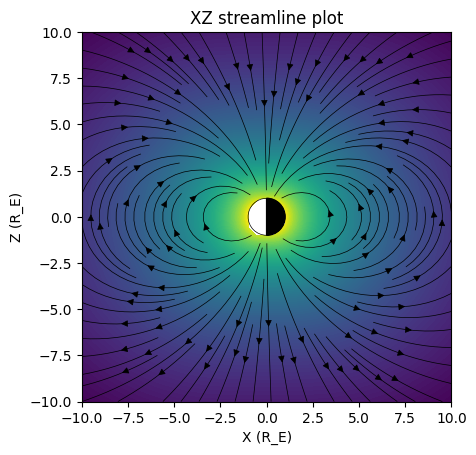

In [26]:
# alpha stretching factor alpha = a + bcos(phi)
# for now a = 1, b = 0 for perfect dipole
alpha = 1
# azimuthal_a = arctan(y/x)

def dipole_field_cartesian(x, y, z):
    B_x = M * 1/alpha * 3*z*x*alpha/((x*alpha)**2+y**2+z**2)**(5/2)
    B_y = M * 1/alpha * (3*z*y)/((x*alpha)**2 + y**2 + z**2)**(5/2)
    B_z = M * 1/alpha * (2 * z**2 - x**2*alpha**2 - y**2)/((x*alpha)**2 + y**2 + z**2)**(5/2)
    return B_x, B_y, B_z

# 2d slices
B_x, B_y, B_z = dipole_field_cartesian(X, Y, Z)
r = np.sqrt(X**2 + Y**2 + Z**2)

# we are avoiding the singularity at the center which seems to be causing strange issues
# also, this part of the earth is not very interesting to us as we are focused on the radii > surface
mask = r < 1   # skip inner 1 Re
B_x[mask] = np.nan
B_y[mask] = np.nan
B_z[mask] = np.nan

# total magnitude at a location diregarding direction
B_mag = (B_x**2 + B_y**2 + B_z**2)**0.5

# XZ slice
y = step // 2       # find the center from the macro
X2 = X[:, y, :].T
Z2 = Z[:, y, :].T
U  = B_x[:, y, :].T
W  = B_z[:, y, :].T

fig, ax = plt.subplots()
ax.streamplot(X2, Z2, U, W, density=1.4, minlength=0.2, color='k', linewidth=0.5)

ax.contourf(X2, Z2, np.log10(B_mag[:, y, :]), levels=120)

# Earth disk at r = 1 Re
w = Wedge((0, 0), 1.0, 270, 90, facecolor='k', edgecolor='k', zorder=5)
c = Circle((0, 0), 1.0, facecolor='none', edgecolor='k', linewidth=0.5, zorder=6)

ax.add_patch(w)
ax.add_patch(c)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (R_E)'); ax.set_ylabel('Z (R_E)')
ax.set_xlim(x_range[0], x_range[-1]); ax.set_ylim(z_range[0], z_range[-1])
ax.set_title("XZ streamline plot")
plt.show()

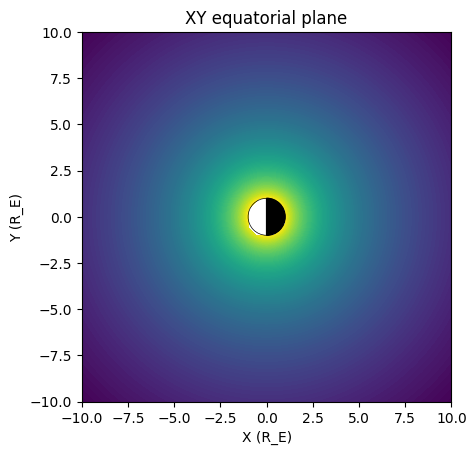

In [27]:
z = step // 2 # get the XY equitorial plane by the center

fig, ax = plt.subplots()

ax.contourf(X[:, :, z], Y[:, :, z], np.log10(B_mag[:, :, z]), levels=120)
ax.streamplot(X[:, :, z].T, Y[:, :, z].T, B_x[:, :, z].T, B_y[:, :, z].T, density=1.4, minlength=0.2)


# Earth at r = 1 Re
w = Wedge((0, 0), 1.0, 270, 90, facecolor='k', edgecolor='k', zorder=5)
c = Circle((0, 0), 1.0, facecolor='none', edgecolor='k', linewidth=0.5, zorder=6)

ax.add_patch(w)
ax.add_patch(c)

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (R_E)'); ax.set_ylabel('Y (R_E)')
ax.set_xlim(x_range[0], x_range[-1]); ax.set_ylim(y_range[0], y_range[-1])
ax.set_title("XY equatorial plane")
plt.show()

#streamline do not show up because they are pointing in and out of the page

Animation of XY equatorial sweep. This could be a useful tool in the future for visualizing 3d fields.

C:\Users\sdimo\AppData\Local\Temp\ipykernel_30228\1475270393.py:31: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cont.collections:


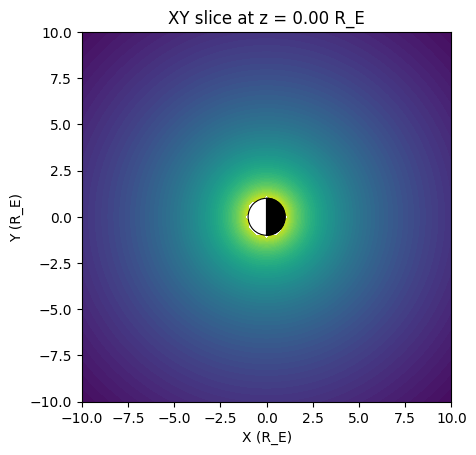

In [28]:
eps = 1e-30

# mask inside Earth everywhere, so colors are consistent across frames
r3d = np.sqrt(X**2 + Y**2 + Z**2)
B_log = np.log10(np.clip(B_mag, eps, None))
B_log = np.where(r3d <= 1.0, np.nan, B_log)

# global color limits so the colormap doesn't change between frames
vmin = np.nanmin(B_log)
vmax = np.nanmax(B_log)

# plotting
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (R_E)'); ax.set_ylabel('Y (R_E)')
ax.set_xlim(x_range[0], x_range[-1]); ax.set_ylim(y_range[0], y_range[-1])
title = ax.set_title("XY slice at z = {:.2f} R_E".format(z_range[len(z_range)//2]))

# placeholders
cont = None
strm = None
earth_patches = []

# draw first frame (center z index)
z_idx0 = len(z_range) // 2
def draw_frame(z_idx):
    global cont, strm, earth_patches

    # remove previous artists cleanly
    if cont is not None:
        for c in cont.collections:
            c.remove()
        cont = None
    if strm is not None:
        for a in (strm.lines + strm.arrows):
            a.remove()
        strm = None
    # remove any existing Earth patches
    for p in earth_patches:
        p.remove()
    earth_patches.clear()

    # slice at current z index
    X2 = X[:, :, z_idx]
    Y2 = Y[:, :, z_idx]
    Blog2 = B_log[:, :, z_idx]

    # filled contours
    cont = ax.contourf(X2, Y2, Blog2, levels=80, vmin=vmin, vmax=vmax, cmap='viridis')

    # streamlines (use transpose so shapes are (Ny, Nx) as streamplot expects with 1D coords)
    U = B_x[:, :, z_idx].T
    V = B_y[:, :, z_idx].T
    # strm = ax.streamplot(x_range, y_range, U, V, density=1.2, minlength=0.2)

    # Earth cross-section at this z
    z_val = z_range[z_idx]
    r_disk = np.sqrt(max(0.0, 1.0 - z_val**2))
    if r_disk > 0:
        # wedge + circle overlay
        w = Wedge((0, 0), r_disk, 270, 90, facecolor='k', edgecolor='k', zorder=5)
        c = Circle((0, 0), r_disk, facecolor='none', edgecolor='k', linewidth=0.8, zorder=6)

        ax.add_patch(w)
        ax.add_patch(c)
        earth_patches.extend([w, c])

    title.set_text("XY slice at z = {:.2f} R_E".format(z_val))

    return []

# init + update for FuncAnimation
def init():
    return draw_frame(z_idx0)

def update(frame):
    return draw_frame(frame)

anim = animation.FuncAnimation(
    fig, update, frames=range(len(z_range)), init_func=init,
    interval=80, blit=False, repeat=True
)


# HTML(anim.to_jshtml())
HTML(anim.to_html5_video())     # needs ffmpeg in PATH
# plt.show()

# To save:
# anim.save('B_xy_sweep.mp4', dpi=150, fps=12, writer='ffmpeg')


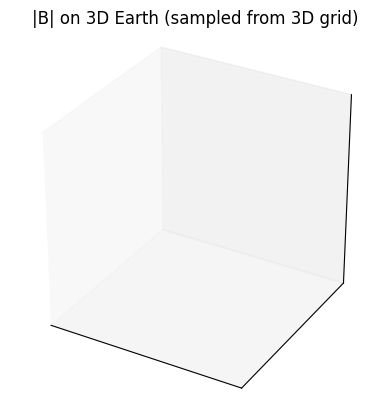

In [29]:
# # trying to plot a 3d version of the contour
# ax = plt.figure().add_subplot(projection='3d')
# z = 25
# ax.contour(X[:,:,z], Y[:,:,z], Z[:,:,z], cmap=cm.coolwarm)  # Plot contour curves
# plt.show()

# ---- Your existing grid ----
# x_range, y_range, z_range defined as in your snippet (all length 51)
# X, Y, Z = np.meshgrid(x_range, y_range, z_range, indexing='ij')

# ---- Your field on that grid ----
# B_mag must be shape (len(x_range), len(y_range), len(z_range))
# and correspond to (i,j,k) indexing = (x,y,z)
# e.g., B_mag[i,j,k] = |B|(x_range[i], y_range[j], z_range[k])


# ---- Build a sphere to sample onto ----
R = 1.0  # Earth radius in your units (you said your coords are in Earth radii)
u = np.linspace(0.0, 2*np.pi, 360)        # longitude
v = np.linspace(-np.pi/2, np.pi/2, 181)   # latitude
U, V = np.meshgrid(u, v)

Xs = R * np.cos(V) * np.cos(U)
Ys = R * np.cos(V) * np.sin(U)
Zs = R * np.sin(V)

# ---- Interpolate your 3D field onto the sphere ----
interp = RegularGridInterpolator(
    (x_range, y_range, z_range), B_mag,
    bounds_error=False, fill_value=np.nan
)
pts = np.column_stack([Xs.ravel(), Ys.ravel(), Zs.ravel()])
B_on_sphere = interp(pts).reshape(Xs.shape)

# ---- Plot only |B| on the globe ----
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Normalize for colormap
Bmin = np.nanmin(B_on_sphere)
Bmax = np.nanmax(B_on_sphere)
Bnorm = (B_on_sphere - Bmin) / (Bmax - Bmin + 1e-12)

surf = ax.plot_surface(
    Xs, Ys, Zs,
    facecolors=plt.cm.viridis(Bnorm),
    linewidth=0, antialiased=False
)

# Colorbar tied to same range
m = plt.cm.ScalarMappable(cmap='viridis')
m.set_array(B_on_sphere)
m.set_clim(Bmin, Bmax)
# cb = plt.colorbar(m, shrink=0.7, pad=0.05)
# cb.set_label('|B|')

ax.set_box_aspect([1,1,1])
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.set_title('|B| on 3D Earth (sampled from 3D grid)')
plt.show()

### Step-by-Step Implementation

#### Step 3a: Create Polar Coordinates
Convert your Cartesian grid to polar coordinates in the equatorial plane ($z=0$):

$$
R = \sqrt{x^2 + y^2} \tag{6}
$$

$$
\theta = \arctan\left(\frac{y}{x}\right) \tag{7}
$$

In [30]:
R = np.sqrt(X**2 + Y**2)
# do i use arctan or arctan2 here?
theta = np.arctan2(Y,X)


#### Step 3b: Calculate the Electric Field
The electric field is the negative gradient of the potential:

$$
E_R = -\frac{\partial \Phi}{\partial R} \tag{8}
$$

$$
E_\theta = -\frac{1}{R}\frac{\partial \Phi}{\partial \theta} \tag{9}
$$

Since our potential only depends on $R$, $E_\theta = 0$ and:

$$
E_R = -\frac{\omega \mu_0 m}{4 \pi R^2 R_E} \tag{10}
$$

In [31]:
w = 2*np.pi/(24*3600)
R_e = 6.378*10**6
m = 8.05e22

E_r = -w*mu_0*m/(4*np.pi*R_e*R**2)
E_theta = 0

C:\Users\sdimo\AppData\Local\Temp\ipykernel_30228\3515032145.py:5: RuntimeWarning: divide by zero encountered in divide
  E_r = -w*mu_0*m/(4*np.pi*R_e*R**2)


#### Step 3c: Transform to Cartesian Coordinates
Convert the electric field back to Cartesian:

$$
E_x = E_R \cos\theta - E_\theta \sin\theta = E_R \cos\theta \tag{11}
$$

$$
E_y = E_R \sin\theta + E_\theta \cos\theta = E_R \sin\theta \tag{12}
$$

$$
E_z = 0 \tag{13}
$$

In [32]:
E_x = E_r*np.cos(theta) - E_theta*np.sin(theta) #= E_r*np.cos(theta)
E_y = E_r*np.sin(theta) + E_theta*np.cos(theta) #= E_r*np.sin(theta)
E_z = 0

C:\Users\sdimo\AppData\Local\Temp\ipykernel_30228\1616678390.py:2: RuntimeWarning: invalid value encountered in multiply
  E_y = E_r*np.sin(theta) + E_theta*np.cos(theta) #= E_r*np.sin(theta)


#### Step 3d: Calculate the Drift Velocity
Compute the cross product $\mathbf{E}\times\mathbf{B}$ and divide by $B^2$:

$$
V_x = \frac{E_y B_z - E_z B_y}{B^2} \tag{14}
$$

$$
V_y = \frac{E_z B_x - E_x B_z}{B^2} \tag{15}
$$

$$
V_z = \frac{E_x B_y - E_y B_x}{B^2} \tag{16}
$$

The drift speed magnitude is:
$$
|\mathbf{V}| = \sqrt{V_x^{2} + V_y^{2} + V_z^{2}}
$$

---

### What to Expect
Plot your corotation drift speeds as contours in the equatorial plane. You should see:
- Drift speeds decreasing with distance (approximately $\sim 1/R^{2}$ dependence)
- Azimuthally symmetric patterns (since $b = 0$)


In [33]:
B2 = B_x**2 + B_y**2 + B_z**2
if np.sum(B2) == 0:
    B2_safe = 1
else:
    B2_safe = 1 / B2
# avoiding dividing by zero?

V_x = (E_y*B_z - E_z*B_y) * B2_safe
V_y = (E_z*B_x - E_x*B_z) * B2_safe
V_z = (E_x*B_y - E_y*B_x) * B2_safe
Vmag = np.sqrt(V_x**2 + V_y**2 + V_z**2)

C:\Users\sdimo\AppData\Local\Temp\ipykernel_30228\2627005173.py:10: RuntimeWarning: invalid value encountered in multiply
  V_z = (E_x*B_y - E_y*B_x) * B2_safe


### Step 4: Gradient–Curvature Drift

This is where things get more complicated. Gradient–curvature drift arises from the non-uniform, curved nature of Earth’s magnetic field. Unlike corotation drift, this depends on particle energy and involves 3D calculations along magnetic field lines.

There are two related effects:

**Gradient Drift:** When particles encounter regions where the magnetic field strength varies spatially, they drift perpendicular to both **B** and ∇B:

Due to differences in strength and magnitude along thw field line

$$
\mathbf{V}_{\text{grad}}=\frac{W_{\perp}}{e\,B^{3}}\;\mathbf{B}\times\nabla B \tag{17}
$$

**Curvature Drift:** The curved geometry of field lines causes particles to drift:

Comes from change in direction (curve) reflecting the acceleration which is a force written to be similar so that they can be added together. 

$$
\mathbf{V}_{\text{curv}}=\frac{W_{\parallel}}{e\,B^{4}}\;\mathbf{B}\times\big((\mathbf{B}\cdot\nabla)\mathbf{B}\big) \tag{18}
$$

**Where:**
- \(W_{\perp},\, W_{\parallel}\) are perpendicular and parallel kinetic energies  
- \(e\) is the elementary charge \((1.602\times10^{-19}\ \text{C})\)  
- \(\nabla B\) is the spatial gradient of magnetic-field magnitude


In [34]:
from scipy.ndimage import gaussian_filter
# For simplicity, assume W⊥ = W∥ = W/2
# Total energy: W = 1 eV (typical plasmasphere energies)
W = 1 #* 1.60218e-19 #J (1eV)

W_perp = W/2
W_parallel = W/2
# del_B = 0

# Stack B and magnitude as vector for later use in numpy
B = np.stack([B_x, B_y, B_z], axis=-1)
B_mag = np.linalg.norm(B, axis=-1)
# B_mag = np.sqrt(Bx**2 + By**2 + Bz**2)
# this is from above

# ∇B_mag (gradient of scalar B_mag)
# np.gradient returns partials in the same order as axes: x, y, z
B_mag_smooth = gaussian_filter(B_mag, sigma=1)
grad_Bmag = np.stack(np.gradient(B_mag_smooth, dx, dy, dz, edge_order=2), axis=-1)
#grad_Bmag = np.stack(np.gradient(B_mag, dx, dy, dz, edge_order=2), axis=-1)  # (...,3)


dBx_dx, dBx_dy, dBx_dz = np.gradient(B_x, dx, dy, dz, edge_order=2)
dBy_dx, dBy_dy, dBy_dz = np.gradient(B_y, dx, dy, dz, edge_order=2)
dBz_dx, dBz_dy, dBz_dz = np.gradient(B_z, dx, dy, dz, edge_order=2)

# (B·∇)B = [Bx*dBx/dx + By*dBx/dy + Bz*dBx/dz,
#           Bx*dBy/dx + By*dBy/dy + Bz*dBy/dz,
#           Bx*dBz/dx + By*dBz/dy + Bz*dBz/dz]
Bdotdel_Bx = B_x*dBx_dx + B_y*dBx_dy + B_z*dBx_dz
Bdotdel_By = B_x*dBy_dx + B_y*dBy_dy + B_z*dBy_dz
Bdotdel_Bz = B_x*dBz_dx + B_y*dBz_dy + B_z*dBz_dz

BdotdelB = np.stack([Bdotdel_Bx, Bdotdel_By, Bdotdel_Bz], axis=-1)

# first try
# V_grad = W_perp / (q_e*B_mag**3) * B cross (del_B)
# V_grad = W_perp / (q_e*B_mag**3) * np.cross(B, grad_Bmag, axis=-1)

# first try
# V_curv = W_parallel/(np.e*B_mag**4) * B cross ((Bdotdel)*B_mag)
# V_curv = W_parallel/(np.e*B_mag**4) * np.cross(B, BdotdelB * B_mag[..., None], axis=-1)

# Prefactors with extra axis for broadcasting
pref_grad = (W_perp     / (q_e * (B_mag**3)))[..., None]
pref_curv = (W_parallel / (q_e * (B_mag**4)))[..., None]

# Drifts
V_grad = pref_grad * np.cross(B, grad_Bmag, axis=-1)
V_curv    = pref_curv * np.cross(B, BdotdelB, axis=-1)   


In [35]:
# --- Precompute once ---
eps  = 1e-30
B_mag = np.sqrt(B_x**2 + B_y**2 + B_z**2)
r3d   = np.sqrt(X**2 + Y**2 + Z**2)
B_log = np.log10(np.clip(B_mag, eps, None))
B_log = np.where(r3d <= 1.0, np.nan, B_log)

vmin, vmax = np.nanmin(B_log), np.nanmax(B_log)

# Downsample factor for quiver arrows
ds = 7
x_coarse = x_range[::ds]
y_coarse = y_range[::ds]
Xc, Yc = np.meshgrid(x_coarse, y_coarse, indexing='xy')   # (Ny_c, Nx_c)

# --- Figure ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(x_range[0], x_range[-1])
ax.set_ylim(y_range[0], y_range[-1])
ax.set_xlabel('X (R_E)'); ax.set_ylabel('Y (R_E)')

z0 = len(z_range) // 2
title = ax.set_title(f"XY slice at z = {z_range[z0]:.2f} R_E")

# Fast image
img = ax.imshow(
    B_log[:, :, z0].T,
    origin='lower',
    extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]],
    vmin=vmin, vmax=vmax, cmap='viridis', interpolation='nearest'
)
cb = plt.colorbar(img, ax=ax, shrink=0.8, pad=0.02)
cb.set_label('log10 |B|')

# Quiver (downsampled); initialize with actual first frame
Ux0 = V_grad[::ds, ::ds, z0, 0].T
Uy0 = V_grad[::ds, ::ds, z0, 1].T
quiv = ax.quiver(
    x_coarse, y_coarse, Ux0, Uy0,
    angles='xy', scale_units='xy', scale=None,
    width=0.0025, headwidth=3, headlength=4
)

# Earth patch holder (mutable so no nonlocal/global needed)
earth = [None]

def draw_frame(k):
    z_val = z_range[k]

    # Update image quickly
    img.set_data(B_log[:, :, k].T)
    title.set_text(f"XY slice at z = {z_val:.2f} R_E")

    # Update quiver vectors (downsampled)
    Ux = V_grad[::ds, ::ds, k, 0].T
    Uy = V_grad[::ds, ::ds, k, 1].T

    # Mask arrows inside Earth's cross-section at this z
    r_disk = np.sqrt(max(0.0, 1.0 - z_val**2))
    if r_disk > 0:
        Rxy = np.sqrt(Xc**2 + Yc**2)
        mask = Rxy <= r_disk
        Ux = np.ma.array(Ux, mask=mask)
        Uy = np.ma.array(Uy, mask=mask)

        if earth[0] is None:
            earth[0] = Circle((0.0, 0.0), r_disk, facecolor='k', alpha=0.25,
                              edgecolor='k', lw=1.0, zorder=5)
            ax.add_patch(earth[0])
        else:
            earth[0].set_radius(r_disk)
            earth[0].set_visible(True)
    else:
        if earth[0] is not None:
            earth[0].set_visible(False)

    # Update quiver in place
    quiv.set_UVC(Ux, Uy)

    return (img, quiv, earth[0]) if earth[0] is not None else (img, quiv)

def init():
    return draw_frame(z0)

anim = animation.FuncAnimation(
    fig, lambda i: draw_frame(i),
    frames=range(len(z_range)), init_func=init,
    interval=60, blit=False, repeat=True
)

plt.close(fig)            # VS Code notebooks: avoid duplicate static image
HTML(anim.to_html5_video())     # display inline without ffmpeg


In [36]:

# eps  = 1e-30
# r3d   = np.sqrt(X**2 + Y**2 + Z**2)
# B_log = np.log10(np.clip(B_mag, eps, None))
# B_log = np.where(r3d <= 1.0, np.nan, B_log)

# vmin, vmax = np.nanmin(B_log), np.nanmax(B_log)

# # decimate for speed (only for streamplot)
# ds = 2
# Xc = X[::ds, ::ds, :]
# Yc = Y[::ds, ::ds, :]
# Vx = V_grad[::ds, ::ds, :, 0]
# Vy = V_grad[::ds, ::ds, :, 1]

# # figure and two axes (image + overlay for streamlines)
# fig, ax_img = plt.subplots(figsize=(8, 6))
# ax_img.set_aspect('equal', adjustable='box')
# ax_img.set_xlim(x_range[0], x_range[-1])
# ax_img.set_ylim(y_range[0], y_range[-1])
# ax_img.set_xlabel('X (R_E)'); ax_img.set_ylabel('Y (R_E)')

# # overlay axes shares limits, no frame/ticks
# ax_flow = fig.add_axes(ax_img.get_position(), frameon=False)
# ax_flow.set_xlim(ax_img.get_xlim()); ax_flow.set_ylim(ax_img.get_ylim())
# ax_flow.set_aspect('equal'); ax_flow.set_axis_off()

# z0 = len(z_range)//2
# title = ax_img.set_title(f"XY slice at z = {z_range[z0]:.2f} R_E")

# # background image 
# img = ax_img.imshow(
#     B_log[:, :, z0].T, origin='lower',
#     extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]],
#     vmin=vmin, vmax=vmax, cmap='viridis', interpolation='nearest'
# )
# cb = plt.colorbar(img, ax=ax_img, shrink=0.8, pad=0.02); cb.set_label('log10 |B|')

# # Earth disk (on image axis, so clearing ax_flow won’t touch it)
# earth = Circle((0.0, 0.0), 0.0, facecolor='k', alpha=0.25, edgecolor='k', lw=1.0, zorder=5)
# ax_img.add_patch(earth)

# # decimate once for faster streamplot
# ds = 2
# x_coarse = x_range[::ds]
# y_coarse = y_range[::ds]

# # remove Xc,Yc and just downsample the vectors:
# Vx = V_grad[::ds, ::ds, :, 0]
# Vy = V_grad[::ds, ::ds, :, 1]


# def draw_frame(k):
#     z_val = z_range[k]

#     # update image & title
#     img.set_data(B_log[:, :, k].T)
#     title.set_text(f"XY slice at z = {z_val:.2f} R_E")

#     # update Earth disk
#     r_disk = float(np.sqrt(max(0.0, 1.0 - z_val**2)))
#     earth.set_radius(r_disk)
#     earth.set_visible(r_disk > 0)

#     # keep overlay axes perfectly aligned
#     ax_flow.cla()
#     ax_flow.set_xlim(ax_img.get_xlim())
#     ax_flow.set_ylim(ax_img.get_ylim())
#     ax_flow.set_aspect('equal')
#     ax_flow.set_axis_off()

#     # slice downsampled drift
#     U = Vx[:, :, k].T  # shape (Ny_c, Nx_c)
#     V = Vy[:, :, k].T

#     # mask inside Earth's disk on this plane
#     if r_disk > 0:
#         # build radial mask on the coarse grid using 1D coords
#         Xc, Yc = np.meshgrid(x_coarse, y_coarse, indexing='xy')  # (Ny_c, Nx_c)
#         Rxy = np.sqrt(Xc**2 + Yc**2)
#         m = Rxy <= r_disk
#         U = np.where(m, np.nan, U)
#         V = np.where(m, np.nan, V)

#     # streamplot
#     ax_flow.streamplot(
#         x_coarse, y_coarse, U, V,
#         color=(0.6, 0.9, 1.0, 0.9), density=1.1,
#         minlength=0.2, arrowsize=1.2, linewidth=1.0, zorder=10
#     )

#     return []


# def init(): return draw_frame(z0)

# anim = animation.FuncAnimation(
#     fig, lambda i: draw_frame(i),
#     frames=range(len(z_range)), init_func=init,
#     interval=80, blit=False, repeat=True
# )

# plt.close(fig)
# HTML(anim.to_jshtml())


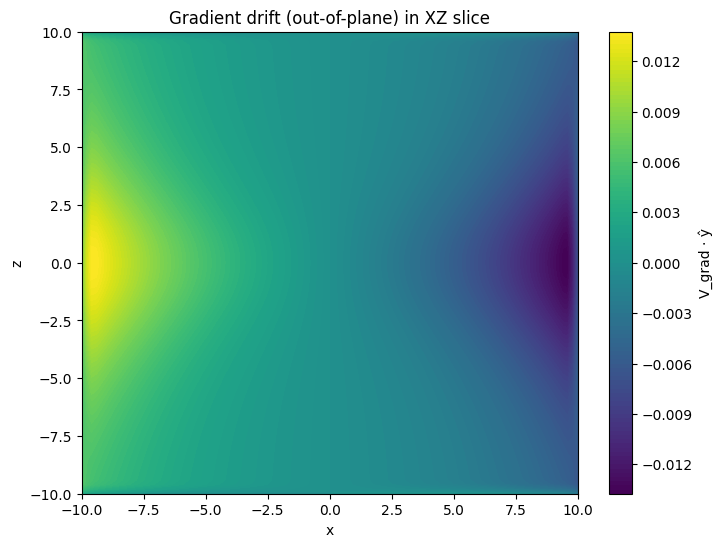

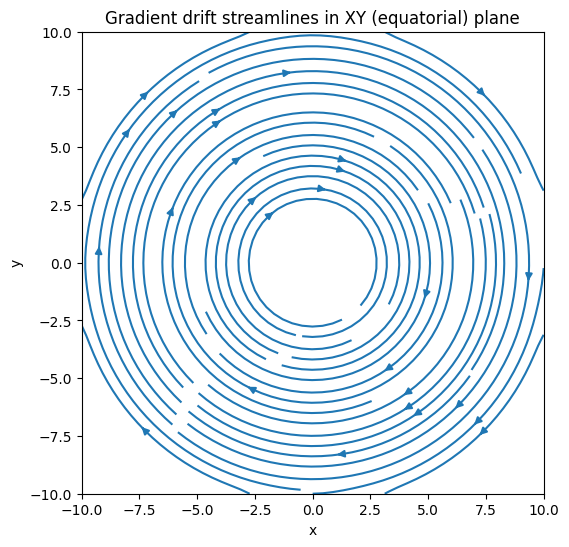

In [37]:
ixy = half_range
Vy_grad = V_grad[:, ixy, :, 1] 

fig, ax = plt.subplots(figsize=(8,6))
im = ax.contourf(X[:, ixy, :].T, Z[:, ixy, :].T, Vy_grad.T, levels=120)
fig.colorbar(im, ax=ax, label='V_grad · ŷ')
ax.set_xlabel('x'); ax.set_ylabel('z')
ax.set_title('Gradient drift (out-of-plane) in XZ slice')
plt.show()


iz = step // 2  # z=0 plane
fig, ax = plt.subplots(figsize=(8,6))
ax.streamplot(X[:, :, iz].T, Y[:, :, iz].T, V_grad[:, :, iz, 0].T, V_grad[:, :, iz, 1].T, density=1.5, minlength=0.5)

ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_title('Gradient drift streamlines in XY (equatorial) plane')
plt.show()

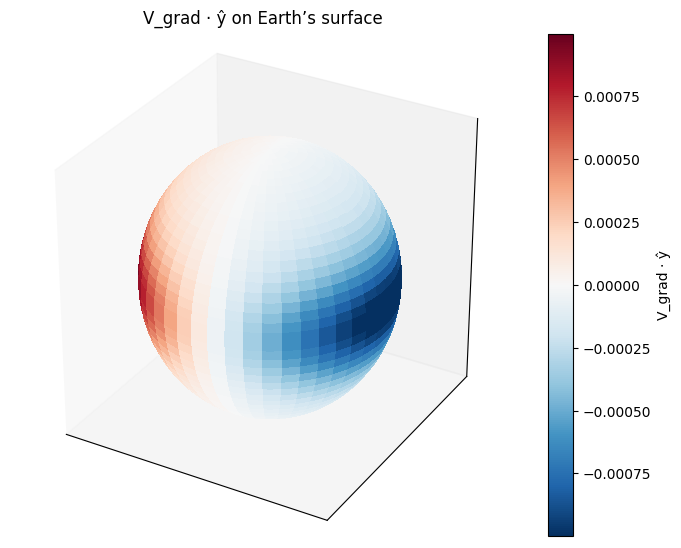

In [38]:
R = 1.0 + 2

u = np.linspace(0.0, 2*np.pi, 360)
v = np.linspace(-np.pi/2, np.pi/2, 181)
U, V = np.meshgrid(u, v)

Xs = R * np.cos(V) * np.cos(U)
Ys = R * np.cos(V) * np.sin(U)
Zs = R * np.sin(V)

# interpolate Vy (use full 3D field, not a slice)
Vy3d = V_grad[:, :, :, 1]  # shape (Nx, Ny, Nz)
interpVy = RegularGridInterpolator(
    (x_range, y_range, z_range), Vy3d,
    bounds_error=False, fill_value=np.nan, method="linear"
)
pts = np.column_stack([Xs.ravel(), Ys.ravel(), Zs.ravel()])
Vy_on_sphere = interpVy(pts).reshape(Xs.shape)

# scaling and colormap (symmetric around 0)
finite = np.isfinite(Vy_on_sphere)
if np.any(finite):
    vmax = np.nanpercentile(np.abs(Vy_on_sphere[finite]), 98)
else:
    vmax = 1.0
vmin = -vmax

norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# Use a diverging cmap and make NaNs visible (gray) instead of transparent
cmap = plt.cm.RdBu_r.copy()
cmap.set_bad((0.6, 0.6, 0.6, 1.0))  # NaNs show up gray

facecolors = cmap(norm(Vy_on_sphere))

# plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(
    Xs, Ys, Zs,
    facecolors=facecolors,
    linewidth=0, antialiased=False, shade=False
)

# a faint wireframe so you see the globe even if many NaNs
ax.plot_wireframe(Xs, Ys, Zs, rstride=24, cstride=24, color='k', linewidth=0.2, alpha=0.25)

# Proper colorbar from a ScalarMappable sharing the same norm/cmap
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(Vy_on_sphere[finite])  # any finite array works
cb = fig.colorbar(mappable, ax=ax, shrink=0.75, pad=0.05)
cb.set_label('V_grad · ŷ')

ax.set_box_aspect([1, 1, 1])
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.set_title('V_grad · ŷ on Earth’s surface')
plt.tight_layout()
plt.show()


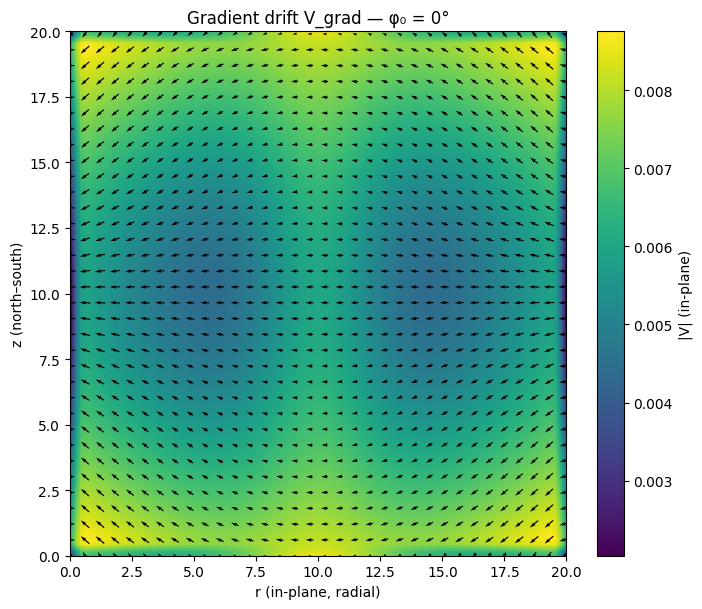

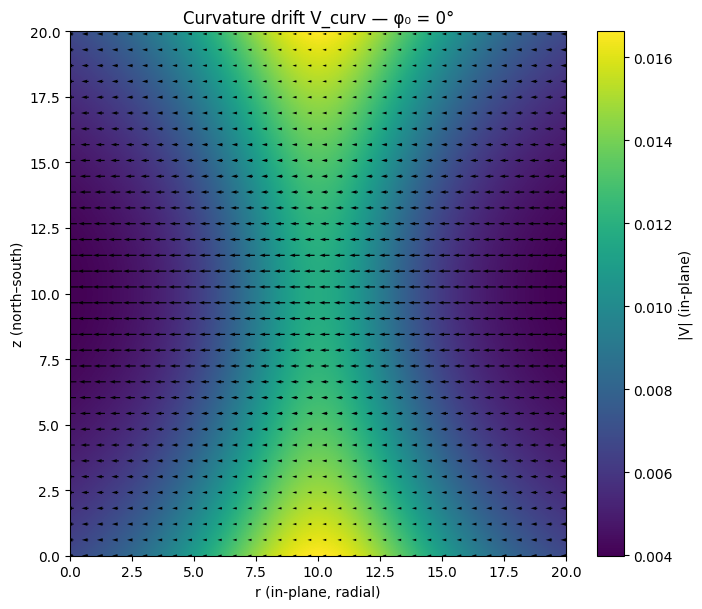

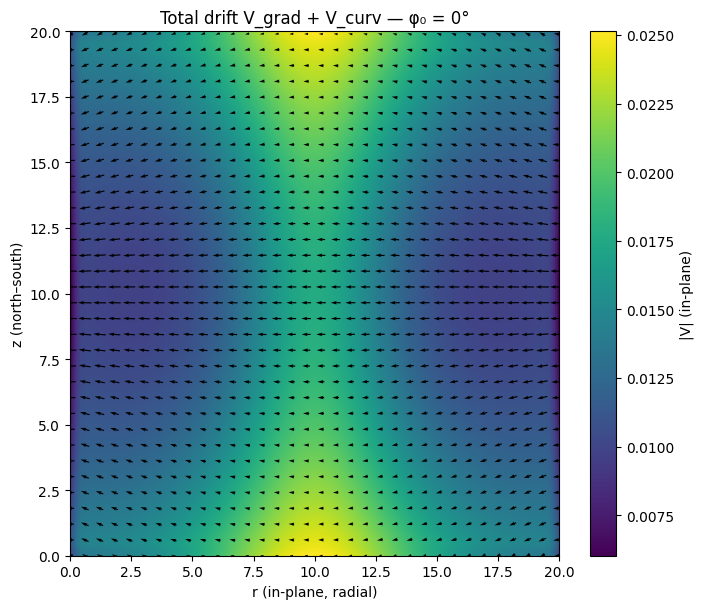

In [39]:

# coordinate helpers (reuse your B_mag shape & spacings)
def build_grid_coords(B_mag, dx, dy, dz, x0=0.0, y0=0.0, z0=0.0):
    Nx, Ny, Nz = B_mag.shape
    x = x0 + np.arange(Nx)*dx
    y = y0 + np.arange(Ny)*dy
    z = z0 + np.arange(Nz)*dz
    return x, y, z

def r_extent_from_xy(x, y, phi0):
    # project all 4 xy-corners onto e_r to get r-range robustly
    xr = [x.min(), x.max()]
    yr = [y.min(), y.max()]
    er = np.array([np.cos(phi0), np.sin(phi0)])
    corners = np.array([[xx, yy] for xx in xr for yy in yr])
    rproj = corners @ er
    return rproj.min(), rproj.max()

def make_interpolator(Vcomp, x, y, z):
    # Vcomp: scalar field (Nx,Ny,Nz)
    return RegularGridInterpolator((x, y, z), Vcomp, bounds_error=False, fill_value=np.nan)

def sample_meridional_plane(V, B_mag, dx, dy, dz, phi0=0.0, nr=200, nz=200):
    """
    Samples vector field V(...,3) on the plane of constant azimuth phi0.
    Returns r grid, z grid, in-plane components Vr, Vz, and |V_inplane|.
    """
    x, y, z = build_grid_coords(B_mag, dx, dy, dz)

    rmin, rmax = r_extent_from_xy(x, y, phi0)
    R = np.linspace(rmin, rmax, nr)
    Z = np.linspace(z.min(), z.max(), nz)
    RR, ZZ = np.meshgrid(R, Z, indexing='xy')

    # plane embedding in Cartesian
    XX = RR * np.cos(phi0)
    YY = RR * np.sin(phi0)

    # interpolators for Vx,Vy,Vz
    Vx_i = make_interpolator(V[...,0], x, y, z)
    Vy_i = make_interpolator(V[...,1], x, y, z)
    Vz_i = make_interpolator(V[...,2], x, y, z)

    pts = np.stack([XX.ravel(), YY.ravel(), ZZ.ravel()], axis=-1)
    Vx = Vx_i(pts).reshape(ZZ.shape)
    Vy = Vy_i(pts).reshape(ZZ.shape)
    Vz = Vz_i(pts).reshape(ZZ.shape)

    # in-plane unit vectors
    e_r  = np.array([np.cos(phi0), np.sin(phi0), 0.0])
    e_z  = np.array([0.0, 0.0, 1.0])

    # project onto (r,z)
    Vr = Vx*e_r[0] + Vy*e_r[1] + Vz*e_r[2]     # = V·e_r
    Vz_comp = Vz                                # = V·e_z
    Vinp_mag = np.sqrt(Vr**2 + Vz_comp**2)

    return R, Z, Vr, Vz_comp, Vinp_mag

def plot_meridional(V, B_mag, dx, dy, dz, phi0=0.0, nr=200, nz=200, step=6, title='Meridional slice (⊥ azimuthal)'):
    R, Z, Vr, Vz_comp, Vinp_mag = sample_meridional_plane(V, B_mag, dx, dy, dz, phi0, nr, nz)

    plt.figure(figsize=(7.2, 6.2))
    im = plt.imshow(Vinp_mag.T, origin='lower', extent=[R.min(), R.max(), Z.min(), Z.max()], aspect='auto')
    plt.colorbar(im, label='|V| (in-plane)')

    # quiver (thin arrows)
    rs = slice(0, len(R), step)
    zs = slice(0, len(Z), step)
    RR, ZZ = np.meshgrid(R, Z, indexing='xy')
    plt.quiver(RR[rs, zs], ZZ[rs, zs], Vr[rs, zs], Vz_comp[rs, zs], pivot='mid', scale=None)

    plt.xlabel('r (in-plane, radial)')
    plt.ylabel('z (north–south)')
    plt.title(f"{title} — φ₀ = {np.degrees(phi0):.0f}°")
    plt.tight_layout()
    plt.show()

# plot three fields on a meridional plane
phi0 = 0.0 # x–z plane (azimuthal direction)
plot_meridional(V_grad, B_mag, dx, dy, dz, phi0=phi0, title='Gradient drift V_grad')
plot_meridional(V_curv, B_mag, dx, dy, dz, phi0=phi0, title='Curvature drift V_curv')
plot_meridional(V_grad + V_curv, B_mag, dx, dy, dz, phi0=phi0, title='Total drift V_grad + V_curv')

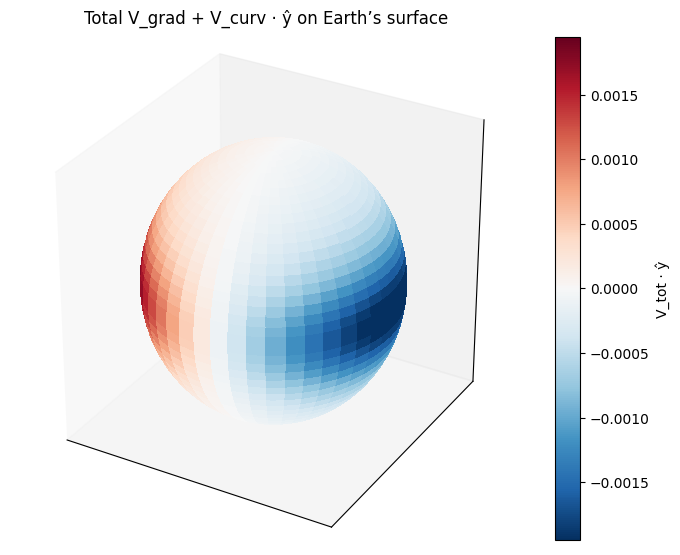

In [40]:
R = 1.0 + 2

u = np.linspace(0.0, 2*np.pi, 360)
v = np.linspace(-np.pi/2, np.pi/2, 181)
U, V = np.meshgrid(u, v)

Xs = R * np.cos(V) * np.cos(U)
Ys = R * np.cos(V) * np.sin(U)
Zs = R * np.sin(V)


# plot_meridional(V_grad + V_curv, B_mag, dx, dy, dz, phi0=phi0, title='Total drift V_grad + V_curv')
# interpolate Vy (use full 3D field, not a slice)
Vy3d = V_grad[:, :, :, 1] + V_curv[:, :, :, 1]  # shape (Nx, Ny, Nz)

interpVy = RegularGridInterpolator(
    (x_range, y_range, z_range), Vy3d,
    bounds_error=False, fill_value=np.nan, method="linear"
)
pts = np.column_stack([Xs.ravel(), Ys.ravel(), Zs.ravel()])
Vy_on_sphere = interpVy(pts).reshape(Xs.shape)

# --- scaling and colormap (symmetric around 0) ---
finite = np.isfinite(Vy_on_sphere)
if np.any(finite):
    vmax = np.nanpercentile(np.abs(Vy_on_sphere[finite]), 98)
else:
    vmax = 1.0
vmin = -vmax

norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# Use a diverging cmap and make NaNs visible (gray) instead of transparent
cmap = plt.cm.RdBu_r.copy()
cmap.set_bad((0.6, 0.6, 0.6, 1.0))  # NaNs show up gray

facecolors = cmap(norm(Vy_on_sphere))

# plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(
    Xs, Ys, Zs,
    facecolors=facecolors,
    linewidth=0, antialiased=False, shade=False
)

# a faint wireframe so you see the globe even if many NaNs
ax.plot_wireframe(Xs, Ys, Zs, rstride=24, cstride=24, color='k', linewidth=0.2, alpha=0.25)

# Proper colorbar from a ScalarMappable sharing the same norm/cmap
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(Vy_on_sphere[finite])  # any finite array works
cb = fig.colorbar(mappable, ax=ax, shrink=0.75, pad=0.05)
cb.set_label('V_tot · ŷ')

ax.set_box_aspect([1, 1, 1])
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.set_title('Total V_grad + V_curv · ŷ on Earth’s surface')
plt.tight_layout()
plt.show()


### The Challenge: Bounce-Averaged Drift

Real particles don’t stay in the equatorial plane—they follow magnetic field lines, bouncing between “mirror points” where the increasing field strength reflects them back. We need to calculate the **bounce-averaged** drift by integrating along entire field-line trajectories.

---

### Understanding Field Line Geometry

In a dipole field, magnetic field lines can be parameterized using **magnetic latitude** \($\lambda$\):

$$
r(\lambda) = \frac{R_0}{\cos^2 \lambda} \tag{19}
$$

where \($R_0$\) is the equatorial crossing distance and \($\lambda$\) ranges from about \(-60^$\circ$\) to \(+60^$\circ$\) (beyond this, field lines become too stretched).

<img src="magnetic_latitudes.png" width="300">



The Cartesian coordinates along a field line are:

$$
x = r(\lambda)\cos\lambda\cos\theta_0 \tag{20}
$$

$$
y = r(\lambda)\cos\lambda\sin\theta_0 \tag{21}
$$

$$
z = r(\lambda)\sin\lambda \tag{22}
$$

where \($\theta_0$\) is the azimuthal angle of the field line.

---

### Implementing the Calculation

**Step 4a: Set Up the Field Line Grid**

For each point \((R,$\theta$)\) in your equatorial grid:

1. Create an array of magnetic latitudes:  
   lambdas = np.linspace(-60deg, 60^deg, N_points)
2. Calculate positions along the field line using the geometry above.
3. Convert to Cartesian coordinates **in meters**.


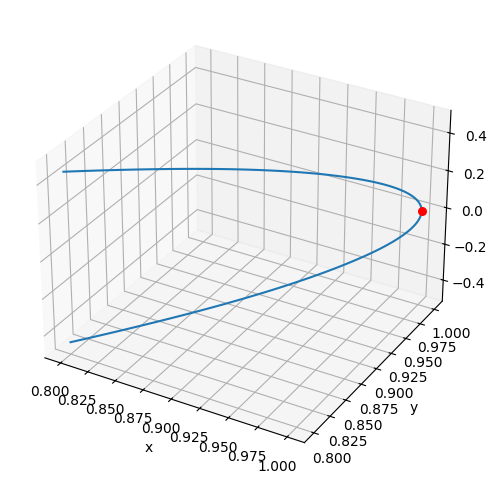

start index on sampled line: 56
B at start (sample): 2.814284989122459e+22
forward mirror: {'index': None, 'position': array([0.90568544, 0.90568544, 0.33500161]), 's': 0.9290219394873078, 'B': 3.7523799854966127e+22}
backward mirror: {'index': None, 'position': array([ 0.90568544,  0.90568544, -0.33500161]), 's': 0.1909616195377597, 'B': 3.7523799854966127e+22}


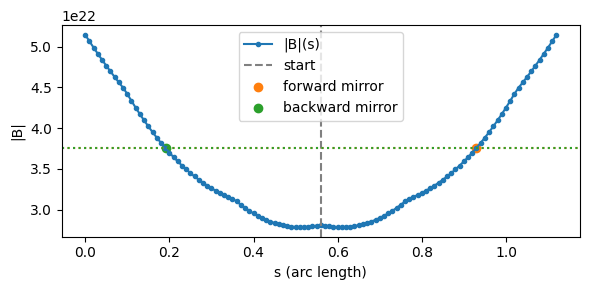

In [50]:
def make_interpolators(x, y, z, Bx, By, Bz, bounds_error=False, fill_value=None):
    """
    Create RegularGridInterpolators for Bx, By, Bz.
    x, y, z : 1D arrays of grid coordinates (may be nonuniform).
    Bx, By, Bz : 3D arrays shaped (len(x), len(y), len(z)).
    """
    pts = (x, y, z)
    iBx = RegularGridInterpolator(pts, Bx, bounds_error=bounds_error, fill_value=fill_value)
    iBy = RegularGridInterpolator(pts, By, bounds_error=bounds_error, fill_value=fill_value)
    iBz = RegularGridInterpolator(pts, Bz, bounds_error=bounds_error, fill_value=fill_value)
    return iBx, iBy, iBz

def get_B_vec(interps, pos):
    """
    pos: (3,) array-like position [x,y,z]
    interps: tuple (iBx, iBy, iBz)
    returns: np.array([Bx,By,Bz]) at pos
    """
    p = np.asarray(pos).reshape(1,3)
    bx = interps[0](p)[0]
    by = interps[1](p)[0]
    bz = interps[2](p)[0]
    return np.array([bx, by, bz], dtype=float)

def rk4_step(func, r, ds):
    """
    Single RK4 step for dr/ds = func(r)
    func: callable r -> drds (3,)
    r: current position (3,)
    ds: step length (positive scalar)
    """
    k1 = func(r)
    k2 = func(r + 0.5*ds*k1)
    k3 = func(r + 0.5*ds*k2)
    k4 = func(r + ds*k3)
    return r + (ds/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def trace_field_line_once(start, interps, xlim, ylim, zlim,
                          ds=0.1, max_steps=10000, min_B=1e-12, direction=1.0):
    """
    Trace a field line from a start point in one direction.

    start: (3,) initial position [x,y,z]
    interps: interpolators tuple created by make_interpolators
    xlim, ylim, zlim: tuples of grid bounds (min, max). Used to stop when leaving domain.
    ds: step size in *distance units of x,y,z coordinates* (positive).
    max_steps: safety limit.
    min_B: if |B| < min_B at a point, stop.
    direction: +1 for forward, -1 for backward along field.

    returns: np.ndarray shape (N,3) path of points including start.
    """
    pts = [np.asarray(start, dtype=float)]
    r = np.asarray(start, dtype=float)

    def inside_bounds(r):
        return (xlim[0] <= r[0] <= xlim[1] and
                ylim[0] <= r[1] <= ylim[1] and
                zlim[0] <= r[2] <= zlim[1])

    def field_dir_at(rpos):
        B = get_B_vec(interps, rpos)
        Bnorm = np.linalg.norm(B)
        if Bnorm <= min_B:
            return None  # signal to stop
        return (B / Bnorm) * direction

    for step in range(max_steps):
        if not inside_bounds(r):
            break
        bhat = field_dir_at(r)
        if bhat is None:
            break

        # define ODE: dr/ds = bhat(r)
        def f(pos):
            v = get_B_vec(interps, pos)
            n = np.linalg.norm(v)
            if n <= min_B:
                return np.zeros(3)
            return v / n * direction

        r_next = rk4_step(f, r, ds)

        # optional: safety if step goes out of bound in-between - clamp or stop
        if not inside_bounds(r_next):
            # try smaller steps to approach boundary
            # simple bisection step: attempt halving step up to 6 times
            r_try = r.copy()
            ds_tmp = ds
            went_in = False
            for _ in range(6):
                ds_tmp *= 0.5
                r_candidate = rk4_step(f, r, ds_tmp)
                if inside_bounds(r_candidate):
                    r_try = r_candidate
                    went_in = True
                else:
                    break
            if went_in:
                r = r_try
                pts.append(r.copy())
            break

        pts.append(r_next.copy())
        r = r_next

    return np.array(pts)

def trace_full_field_line(start, interps, x, y, z,
                          ds=0.1, max_steps=10000, min_B=1e-12):
    """
    Trace both directions from start and combine into one ordered array:
    backward branch (excluding start), reversed + start + forward branch (excluding start).

    x, y, z are the grid coordinate arrays (1D) used to get domain bounds.
    """
    xlim = (x[0], x[-1])
    ylim = (y[0], y[-1])
    zlim = (z[0], z[-1])

    forward = trace_field_line_once(start, interps, xlim, ylim, zlim,
                                     ds=ds, max_steps=max_steps, min_B=min_B, direction=1.0)
    backward = trace_field_line_once(start, interps, xlim, ylim, zlim,
                                      ds=ds, max_steps=max_steps, min_B=min_B, direction=-1.0)

    # Remove duplicate start in concatenation
    # backward contains start as first point, so drop last element when concatenating reversed backward
    if backward.shape[0] > 1:
        backbone = np.vstack((backward[::-1][:-1], forward))
    else:
        backbone = forward
    return backbone

def find_mirror_points(line, Bmag, i0, alpha0, tol=1e-12):
    """
    Find mirror points along a sampled field line.

    Parameters
    ----------
    line : (N,3) array of coordinates ordered along the field line (arc-length order).
    Bmag : (N,) array of |B| at each point.
    i0 : int index in [0, N-1] where the particle starts.
    alpha0 : float initial pitch angle in radians at i0 (angle between v and B).
    tol : small tolerance to protect division by zero.

    Returns
    -------
    mirror_forward : dict or None
        {'index': idx, 'position': pos (3,), 's': s_value, 'B': B_at_mirror}
        Mirror point in the forward direction (increasing index). None if not found.
    mirror_backward : dict or None
        Same as above for backward direction (decreasing index).
    """
    N = len(Bmag)
    if not (0 <= i0 < N):
        raise ValueError("i0 out of range")

    sin2 = np.sin(alpha0)**2
    if sin2 <= tol:
        # pitch angle ~ 0 => particle moves nearly parallel; no perpendicular energy to mirror
        return None, None

    Bstart = Bmag[i0]
    Bm = Bstart / sin2  # required mirror field magnitude

    # Quick check: if Bmax <= Bm there is no mirror along entire line
    Bmax = np.max(Bmag)
    if Bmax < Bm - 1e-15:
        return None, None

    # compute arc-length s for interpolation and nicer outputs
    diffs = np.linalg.norm(np.diff(line, axis=0), axis=1)
    s = np.concatenate(([0.0], np.cumsum(diffs)))  # length N

    def locate_on_branch(start_idx, step):
        # step = +1 (forward) or -1 (backward)
        idx = start_idx
        # If starting point already has B >= Bm (possible if alpha0 small),
        # then either immediate mirror (at start) or it is on stronger B region.
        # Search for first idx != start_idx where B >= Bm.
        # Move outward until condition met or domain exhausted.
        while 0 <= idx < N:
            if idx != start_idx and Bmag[idx] >= Bm:
                # bracket found between idx-1 and idx (or idx and idx+1 if step==-1)
                i_high = idx
                i_low = idx - 1 if step == +1 else idx + 1
                # ensure indices inside bounds
                if not (0 <= i_low < N):
                    # mirror occurs at boundary point
                    pos = line[i_high].copy()
                    return {'index': i_high, 'position': pos, 's': s[i_high], 'B': Bmag[i_high]}
                # linear interpolate in B vs s to find s_m where B = Bm
                B_low, B_high = Bmag[i_low], Bmag[i_high]
                s_low, s_high = s[i_low], s[i_high]
                if abs(B_high - B_low) <= 0:
                    frac = 0.0
                else:
                    frac = (Bm - B_low) / (B_high - B_low)
                frac = np.clip(frac, 0.0, 1.0)
                s_m = s_low + frac * (s_high - s_low)
                pos_m = line[i_low] + frac * (line[i_high] - line[i_low])
                return {'index': None, 'position': pos_m, 's': s_m, 'B': Bm}
            idx += step
        return None

    mirror_forward = locate_on_branch(i0, step=+1)
    mirror_backward = locate_on_branch(i0, step=-1)
    return mirror_forward, mirror_backward

def B_magnitude_along_line(line, interps):
    """Return Bmag array for points in `line` using the same interpolators."""
    Blist = np.array([get_B_vec(interps, p) for p in line])
    return np.linalg.norm(Blist, axis=1)

def mirror_points_from_seed(start, alpha0, interps, x, y, z,
                            ds=0.05, max_steps=5000, min_B=1e-12):
    """
    Trace the field line through `start`, compute |B| along it, and find mirror points
    for a particle launched at `start` with pitch angle alpha0 (radians).

    Returns:
      line : (N,3) array of traced points (backward->forward ordering as in trace_full_field_line)
      Bmag : (N,) array of |B| at each sampled point
      i0 : integer index on `line` corresponding to the start (nearest point)
      mirror_forward, mirror_backward : dicts or None (as returned by find_mirror_points)
    """
    # Trace full line (both directions) using the tracer you already have
    line = trace_full_field_line(start, interps, x, y, z, ds=ds, max_steps=max_steps, min_B=min_B)

    if line is None or len(line) == 0:
        raise RuntimeError("Field-line tracing returned no points.")

    # Compute B magnitude along the line
    Bmag = B_magnitude_along_line(line, interps)

    # Find nearest sample index to the true start (in case of float rounding)
    dists = np.linalg.norm(line - np.asarray(start).reshape(1,3), axis=1)
    i0 = int(np.argmin(dists))

    # If |B| at i0 is extremely small, warn and return (no mirror computation)
    if Bmag[i0] <= min_B:
        return line, Bmag, i0, None, None

    # Use the previously provided find_mirror_points routine
    mf, mb = find_mirror_points(line, Bmag, i0, alpha0)

    return line, Bmag, i0, mf, mb


# Example usage:
if __name__ == "__main__":

    interps = make_interpolators(x_range, y_range, z_range, B_x, B_y, B_z, bounds_error=False, fill_value=None)

    start = np.array([1.0, 1.0, 0.0])
    line = trace_full_field_line(start, interps,x_range, y_range, z_range, ds=0.01, max_steps=5000)

    # Quick plot (requires matplotlib)
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(line[:,0], line[:,1], line[:,2], linewidth=1.5)
    ax.scatter([start[0]], [start[1]], [start[2]], color='red', s=30)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
    plt.show()

    alpha0_deg = 60.0
    alpha0 = np.deg2rad(alpha0_deg)

    line, Bmag, i0, mf, mb = mirror_points_from_seed(start, alpha0, interps, x_range, y_range, z_range, ds=0.01)

    print("start index on sampled line:", i0)
    print("B at start (sample):", Bmag[i0])
    print("forward mirror:", mf)
    print("backward mirror:", mb)

    # optional quick visualization of B(s) and mirror thresholds
  
    # compute arc length s
    s = np.concatenate(([0.0], np.cumsum(np.linalg.norm(np.diff(line, axis=0), axis=1))))
    plt.figure(figsize=(6,3))
    plt.plot(s, Bmag, '-o', label='|B|(s)', markersize=3)
    # mark start
    plt.axvline(s[i0], color='gray', linestyle='--', label='start')
    # if mirrors found, mark them
    if mf is not None:
        plt.scatter([mf['s']], [mf['B']], color='C1', label='forward mirror')
        plt.axhline(y=mf['B'], color='C1', linestyle=':')
    if mb is not None:
        plt.scatter([mb['s']], [mb['B']], color='C2', label='backward mirror')
        plt.axhline(y=mb['B'], color='C2', linestyle=':')
    plt.xlabel('s (arc length)')
    plt.ylabel('|B|')
    plt.legend()
    plt.tight_layout()
    plt.show()

previous code: (clean through, not working atm)

In [42]:
# N_points = 300
# # we don't care too much about the poles at the top so we exclude them in the angles
# lambda1 = np.linspace(-np.deg2rad(60), np.deg2rad(60), N_points)

# # compute spherical r as a function of lambda
# R0 = R[..., None]
# theta0 = theta[..., None]
# r = R0 / np.cos(lambda1)**2

# # converting to cartesian coordinates
# # is theta here the initial theta for local coords?
# # should i use a diff one here?
# x = r * np.cos(lambda1) * np.cos(theta0)
# y = r * np.cos(lambda1) * np.sin(theta0)
# z = r * np.sin(lambda1)

# x_m = X*R_e
# y_m = Y*R_e
# z_m = Z*R_e

In [43]:
# This is the array containing the pitch angle values that we use in our model (HEIDI)
pa_vals = np.radians(np.array([
    90.0, 88.22712893355758, 86.48807675190189, 84.78066618482112,
    83.10289066291055, 81.45289213260543, 79.82894204529823,
    78.22942493766426, 76.65282413626882, 75.09770920860085,
    73.56272485151750, 72.04658096150891, 70.54804367272210,
    69.06592718089553, 67.59908619614974, 66.14640888633875,
    64.70681018638570, 63.27922535839237, 61.86260369275807,
    60.45590224228054, 59.05807947924130, 57.66808875958719,
    56.28487146805731, 54.90734970273195, 53.53441833590207,
    52.16493625879701, 50.79771657834769, 49.43151548167405,
    48.06501941396668, 46.69683012161708, 45.32544698585108,
    43.94924589966404, 42.56645370327326, 41.17511686171378,
    39.77306259855985, 38.35785002352708, 36.92670779994762,
    35.47645341334257, 34.00338682757756, 32.50314773821004,
    30.97051983961422, 29.39915581751508, 27.78117987144701,
    26.10659373721616, 24.36235279936417, 22.53085674336089,
    20.58732659437206, 18.65, 17.12323556683859, 16.0,
    14.33497678947813, 12.24490817598658, 10.62580982962290,
    9.33910764639475, 8.29533207892886, 7.43412959291112,
    6.71333679179085, 6.10263830460587, 5.57970452452312,
    5.12774512214319, 4.73390735224537, 4.38819748406328,
    4.08273657779479, 3.81123588507862, 3.56862001603011,
    3.35075165671591, 3.15422740810418, 2.5, 1.5, 1.0, 0.0, 90.0
]))

In [44]:
# Helper: wrap your RegularGridInterpolators into a vector B(r) callable

def bvec_from_interps(interps):
    iBx, iBy, iBz = interps
    def bvec(pos):
        # pos: (3,) array-like (x,y,z)
        p = np.asarray(pos).reshape(1,3)
        bx = iBx(p)[0]
        by = iBy(p)[0]
        bz = iBz(p)[0]
        return np.array([bx, by, bz], dtype=float)
    return bvec


# RK4 single-step (same as earlier)
def rk4_step(func, r, ds):
    k1 = func(r)
    k2 = func(r + 0.5*ds*k1)
    k3 = func(r + 0.5*ds*k2)
    k4 = func(r + ds*k3)
    return r + (ds/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# Trace a field line in both directions using bvec callable and domain limits
def trace_full_line(seed, bvec_func, xlim, ylim, zlim, ds=0.05, max_steps=20000, min_B=1e-12):
    """
    Trace both directions from seed. Returns:
      line (N,3), Bmag (N,), s (N,) cumulative arc length, idx_seed (index of seed in line)
    """
    def inside(r):
        return (xlim[0] <= r[0] <= xlim[1] and
                ylim[0] <= r[1] <= ylim[1] and
                zlim[0] <= r[2] <= zlim[1])

    def step_dir(direction):
        pts = [seed.copy()]
        r = seed.copy()
        for _ in range(max_steps):
            if not inside(r):
                break
            Bv = bvec_func(r)
            Bn = np.linalg.norm(Bv)
            if Bn <= min_B:
                break
            # normalized field direction times direction (+1 or -1)
            def f(pos):
                b = bvec_func(pos)
                n = np.linalg.norm(b)
                if n <= min_B:
                    return np.zeros(3)
                return (b / n) * direction
            r_next = rk4_step(f, r, ds)
            if not inside(r_next):
                break
            pts.append(r_next.copy())
            r = r_next
        return np.asarray(pts)

    forward = step_dir(+1)
    backward = step_dir(-1)

    if backward.shape[0] > 1:
        backward_rev = backward[::-1]
        full = np.vstack((backward_rev[:-1], forward))
    else:
        full = forward

    # compute B magnitude along full line
    Bmag = np.array([np.linalg.norm(bvec_func(p)) for p in full])
    # arc length
    s = np.concatenate(([0.0], np.cumsum(np.linalg.norm(np.diff(full, axis=0), axis=1))))
    # index of seed (nearest)
    idx_seed = int(np.argmin(np.linalg.norm(full - seed.reshape(1,3), axis=1)))
    return full, Bmag, s, idx_seed

# vectorized per-segment I/h terms (single Bm)
def per_segment_Ih_terms(Bnodes, ds_segments, Bm, tol=1e-14):
    Bi = Bnodes[:-1].astype(float)
    Bi1 = Bnodes[1:].astype(float)
    ds = ds_segments.astype(float)
    denom = (Bi - Bi1)
    A = np.maximum(Bm - Bi, 0.0)
    B = np.maximum(Bm - Bi1, 0.0)

    I_terms = np.zeros_like(ds)
    h_terms = np.zeros_like(ds)

    mask = np.abs(denom) > tol
    if np.any(mask):
        I_terms[mask] = (2.0/3.0) * (1.0/np.sqrt(Bm)) * (ds[mask] / denom[mask]) * (B[mask]**1.5 - A[mask]**1.5)
        h_terms[mask] = 2.0 * np.sqrt(Bm) * (ds[mask] / denom[mask]) * (np.sqrt(B[mask]) - np.sqrt(A[mask]))

    if np.any(~mask):
        idxs = np.where(~mask)[0]
        val = np.maximum(Bm - Bi[idxs], 0.0)
        # I limit
        I_terms[idxs] = ds[idxs] * np.sqrt(val / Bm)
        # h limit (avoid division by zero)
        nz = val > 0
        if np.any(nz):
            ids_nz = idxs[nz]
            h_terms[ids_nz] = ds[ids_nz] * np.sqrt(Bm / val[nz])

    # zero where both A and B are zero
    zero_mask = (A == 0.0) & (B == 0.0)
    I_terms[zero_mask] = 0.0
    h_terms[zero_mask] = 0.0

    return I_terms, h_terms


# locate mirror s along sampled s,B arrays (linear interp)
# returns s_m_forward (>= s_seed) and s_m_backward (<= s_seed) or None
def locate_mirrors_linear(s, Bmag, s_seed, Bm):
    N = len(s)
    # forward
    s_m_f = None
    for i in range(np.searchsorted(s, s_seed), N):
        if Bmag[i] >= Bm:
            if i == 0:
                s_m_f = s[i]
            else:
                i0 = max(i-1, 0)
                s_low, s_high = s[i0], s[i]
                B_low, B_high = Bmag[i0], Bmag[i]
                if abs(B_high - B_low) < 1e-16:
                    frac = 0.0
                else:
                    frac = (Bm - B_low) / (B_high - B_low)
                frac = float(np.clip(frac, 0.0, 1.0))
                s_m_f = s_low + frac * (s_high - s_low)
            break

    # backward
    s_m_b = None
    idx_eq = np.searchsorted(s, s_seed)
    if idx_eq >= N:
        idx_eq = N-1
    for i in range(idx_eq, -1, -1):
        if Bmag[i] >= Bm:
            if i == N-1:
                s_m_b = s[i]
            else:
                i0 = i
                s_low, s_high = s[i0], s[i0+1]
                B_low, B_high = Bmag[i0], Bmag[i0+1]
                if abs(B_high - B_low) < 1e-16:
                    frac = 0.0
                else:
                    frac = (Bm - B_low) / (B_high - B_low)
                frac = float(np.clip(frac, 0.0, 1.0))
                s_m_b = s_low + frac * (s_high - s_low)
            break

    return s_m_f, s_m_b


# integrate I,h from seed index to s_m using per-segment sums and per-seed R0 in meters
def integrate_Ih_from_seed_to_sm(line, Bmag, s, idx_seed, s_m, Bm, R0_seed_m):
    if s_m is None:
        return None, None
    # build node arrays starting at idx_seed
    Bnodes = Bmag[idx_seed:]
    s_nodes = s[idx_seed:]
    ds_segments = np.diff(s_nodes)
    if len(ds_segments) == 0:
        return 0.0, 0.0

    # find the first node index p (in Bnodes) where Bnodes[p] >= Bm
    p = None
    for i in range(len(Bnodes)):
        if Bnodes[i] >= Bm:
            p = i
            break
    if p is None:
        return None, None

    I_sum = 0.0
    h_sum = 0.0
    # full segments up to p-1
    if p > 0:
        I_terms, h_terms = per_segment_Ih_terms(Bnodes[:p+1], ds_segments[:p], Bm)
        I_sum += I_terms.sum()
        h_sum += h_terms.sum()

    # partial last segment (if p>0)
    if p > 0:
        i_low = p-1
        s_low, s_high = s_nodes[i_low], s_nodes[i_low+1]
        B_low, B_high = Bnodes[i_low], Bnodes[i_low+1]
        if abs(B_high - B_low) < 1e-16:
            frac = 0.0
        else:
            frac = (Bm - B_low) / (B_high - B_low)
        frac = float(np.clip(frac, 0.0, 1.0))
        ds_partial = (s_high - s_low) * frac
        Bi = B_low
        Bi1p = Bi + frac * (B_high - Bi)
        I_part, h_part = per_segment_Ih_terms(np.array([Bi, Bi1p]), np.array([ds_partial]), Bm)
        I_sum += float(I_part[0])
        h_sum += float(h_part[0])

    I_val = (1.0 / R0_seed_m) * I_sum
    h_val = (1.0 / (2.0 * R0_seed_m)) * h_sum
    return I_val, h_val

# High-level function: compute I/h grids for all seeds and alphas
def compute_Ih_grid_from_interpolators(interps, x, y, z,
                                       r_vals_Re, theta_vals_rad, alphas_rad,
                                       z_seed=0.0,
                                       ds_trace=0.05, max_steps=20000, min_B=1e-12,
                                       R_E=6.371e6):
    """
    interps: tuple (iBx,iBy,iBz) from make_interpolators on grids x,y,z (units expected same as x,y,z)
    x,y,z: original grid coordinate arrays (used to get domain limits)
    r_vals_Re: 1D radial seed array in Re
    theta_vals_rad: 1D azimuth in radians
    alphas_rad: 1D equatorial pitch angles in radians
    Returns dict of arrays with shape (nr, ntheta, nalpha)
    """
    bvec = bvec_from_interps(interps)

    # domain limits from x,y,z arrays
    xlim = (x[0], x[-1])
    ylim = (y[0], y[-1])
    zlim = (z[0], z[-1])

    nr = len(r_vals_Re)
    ntheta = len(theta_vals_rad)
    nalpha = len(alphas_rad)

    # allocate outputs
    I_f = np.full((nr, ntheta, nalpha), np.nan)
    h_f = np.full((nr, ntheta, nalpha), np.nan)
    I_b = np.full((nr, ntheta, nalpha), np.nan)
    h_b = np.full((nr, ntheta, nalpha), np.nan)
    mirror_f = np.zeros((nr, ntheta, nalpha), dtype=bool)
    mirror_b = np.zeros((nr, ntheta, nalpha), dtype=bool)
    s_m_f = np.full((nr, ntheta, nalpha), np.nan)
    s_m_b = np.full((nr, ntheta, nalpha), np.nan)

    total = nr * ntheta
    count = 0
    for ir, r_re in enumerate(r_vals_Re):
        for it, th in enumerate(theta_vals_rad):
            count += 1
            # build seed in same coordinate units as x,y,z (we assume x,y,z are in Re)
            seed = np.array([r_re * np.cos(th), r_re * np.sin(th), z_seed], dtype=float)
            # trace line
            try:
                line, Bmag, s, idx_seed = trace_full_line(seed, bvec, xlim, ylim, zlim,
                                                          ds=ds_trace, max_steps=max_steps, min_B=min_B)
            except Exception as e:
                # skip on tracer error
                print(f"Trace failed for seed r={r_re}, th={np.degrees(th):.1f}°: {e}")
                continue

            if line is None or len(line) < 2:
                continue

            # IMPORTANT: convert arc-length s (which is in grid units) to meters if x,y,z were in Re
            # We assume x,y,z and thus seed and line coordinates are in Re -> convert to meters
            # If your x,y,z are already in meters, remove these multiplications.
            line_m = line * R_E
            s_m = s * R_E
            Bmag_vals = Bmag  # B interpolator outputs should be in Tesla already

            # compute per-seed R0 in meters (Option A)
            R0_seed_m = r_re * R_E

            # for each pitch angle compute mirrors and integrals
            for ia, alpha in enumerate(alphas_rad):
                sin2 = np.sin(alpha)**2
                if sin2 <= 1e-14:
                    continue
                Bstart = Bmag_vals[idx_seed]
                Bm = Bstart / sin2

                # locate mirrors (linear between sampled nodes)
                s_m_forward, s_m_backward = locate_mirrors_linear(s_m, Bmag_vals, s_m[idx_seed], Bm)

                # forward integrals
                if s_m_forward is not None:
                    Ival, hval = integrate_Ih_from_seed_to_sm(line_m, Bmag_vals, s_m, idx_seed, s_m_forward, Bm, R0_seed_m)
                    if Ival is not None and hval is not None:
                        I_f[ir, it, ia] = Ival
                        h_f[ir, it, ia] = hval
                        mirror_f[ir, it, ia] = True
                        s_m_f[ir, it, ia] = s_m_forward

                # backward integrals (reverse arrays)
                if s_m_backward is not None:
                    # reverse line and Bmag, recompute s_m in reversed coords
                    line_rev_m = line_m[::-1].copy()
                    Bmag_rev = Bmag_vals[::-1].copy()
                    s_rev = np.concatenate(([0.0], np.cumsum(np.linalg.norm(np.diff(line_rev_m, axis=0), axis=1))))
                    idx_rev = len(line_rev_m) - 1 - idx_seed
                    # s_m_backward in original meters; convert to reversed coordinate
                    s_total = s_m[-1]
                    s_m_rev = s_total - s_m_backward
                    Ival_b, hval_b = integrate_Ih_from_seed_to_sm(line_rev_m, Bmag_rev, s_rev, idx_rev, s_m_rev, Bm, R0_seed_m)
                    if Ival_b is not None and hval_b is not None:
                        I_b[ir, it, ia] = Ival_b
                        h_b[ir, it, ia] = hval_b
                        mirror_b[ir, it, ia] = True
                        s_m_b[ir, it, ia] = s_m_backward

            # optional progress
            if (count % 50) == 0 or count == total:
                print(f"Traced {count}/{total} seeds (r={r_re:.3f}, th={np.degrees(th):.1f}°)")

    results = {
        'r_vals_Re': np.asarray(r_vals_Re),
        'theta_vals_rad': np.asarray(theta_vals_rad),
        'alphas_rad': np.asarray(alphas_rad),
        'I_f': I_f, 'h_f': h_f, 'I_b': I_b, 'h_b': h_b,
        'mirror_f': mirror_f, 'mirror_b': mirror_b,
        's_m_f': s_m_f, 's_m_b': s_m_b
    }
    return results


In [45]:
r_vals = np.arange(2.0, 6.75, 0.25)
theta_vals = np.radians(np.arange(360, -15, -15))
alphas = pa_vals
interps = make_interpolators(x_range, y_range, z_range, B_x, B_y, B_z, bounds_error=False, fill_value=None)
res = compute_Ih_grid_from_interpolators(interps,x_range, y_range, z_range, r_vals, theta_vals, alphas,
                          z_seed=0.0,ds_trace=0.05)

Traced 50/475 seeds (r=2.250, th=0.0°)
Traced 100/475 seeds (r=2.750, th=0.0°)
Traced 150/475 seeds (r=3.250, th=0.0°)
Traced 200/475 seeds (r=3.750, th=0.0°)
Traced 250/475 seeds (r=4.250, th=0.0°)
Traced 300/475 seeds (r=4.750, th=0.0°)
Traced 350/475 seeds (r=5.250, th=0.0°)
Traced 400/475 seeds (r=5.750, th=0.0°)
Traced 450/475 seeds (r=6.250, th=0.0°)
Traced 475/475 seeds (r=6.500, th=0.0°)


In [46]:
I = res['I_f'] + res['I_b']
h = res['h_f'] + res['h_b']

In [47]:
energy = 1 * q_e  # 1 eV particle
M_e = 7.94e22  # T·m³
BAVgc = np.zeros_like(I)  # same shape as I and H

for i, r in enumerate(r_vals):
    R0 = r * 6.371e6  # m
    BAVgc[i, :, :] = 3 * energy * R0**2 / (q_e * M_e) * (1 - I[i, :, :] / (6 * h[i, :, :]))

C:\Users\sdimo\AppData\Local\Temp\ipykernel_30228\1373999620.py:7: RuntimeWarning: invalid value encountered in divide
  BAVgc[i, :, :] = 3 * energy * R0**2 / (q_e * M_e) * (1 - I[i, :, :] / (6 * h[i, :, :]))


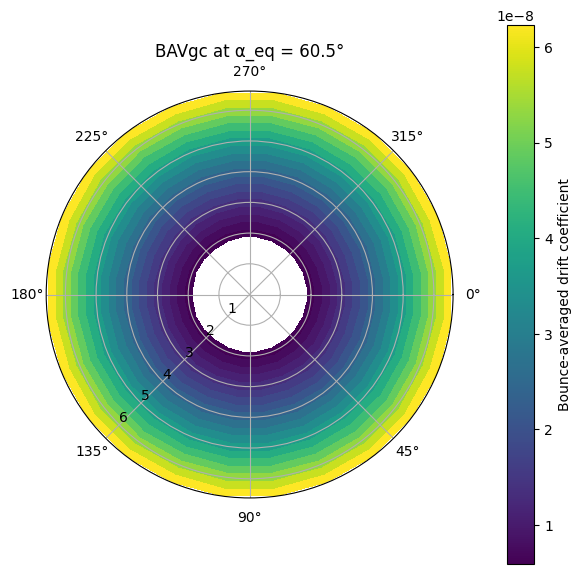

In [ ]:
alpha_index = 19
BAV_slice = BAVgc[:, :, alpha_index]
R, TH = np.meshgrid(r_vals, theta_vals, indexing='ij')
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7, 7))

pcm = ax.pcolormesh(TH, R, BAV_slice, shading='auto')

cb = plt.colorbar(pcm, ax=ax, pad=0.1)
cb.set_label("Bounce-averaged drift coefficient")

ax.set_title(f"BAVgc at α_eq = {np.degrees(alphas[alpha_index]):.1f}°")
ax.set_theta_zero_location("E") 
ax.set_theta_direction(-1)       
ax.set_rlabel_position(135)     

plt.show()

#### Step 4b: Calculate Magnetic Field Properties

At each point along the field line:

1. Evaluate **B**\((x,y,z)\) using your magnetic-field function.  
2. Calculate field magnitude: $B = \lVert \mathbf{B} \rVert \ $
3. Compute the spatial gradient \( $\nabla B \ $) using finite differences.

**Computing Gradients — use `np.gradient()` carefully:**

In [ ]:
# Calculate gradient of B along the field line
# dB_ds = np.gradient(B_magnitude , s) # where s is distance along fieldline

# # Stack B and magnitude as vector for later use in numpy
# B = np.stack([B_x, B_y, B_z], axis=-1)
B_magnitude = np.linalg.norm(B, axis=-1)

# check this below 
p0 = int(np.argmin(np.abs(lambda1)))
B_line_mag = np.linalg.norm(np.stack([B_x[:, p0], B_y[:, p0], B_z[:, p0]], axis=-1), axis=-1)  # (N,)

# B_mag = np.sqrt(Bx**2 + By**2 + Bz**2)
dr = np.stack([np.diff(B_x), np.diff(B_y), np.diff(B_z)])
ds_seg = np.linalg.norm(dr, axis=1)  
s = np.concatenate([[0.0], np.cumsum(ds_seg)])

print(s)

s_unique, idx_unique = np.unique(s, return_index=True)
B_line_mag = B_line_mag[idx_unique]
s = s_unique


dB_ds = np.gradient(B_magnitude, s) # where s is distance along fieldline

NameError: name 'lambda1' is not defined

### Step 4c: Calculate Local Drift Velocities

At each field line point, compute:

---

#### 1. Gradient drift, Curvature drift

In [ ]:
# B_cross_gradB = np.cross(B_vector, grad_B_vector)
# V_grad = (W_perp / e) * B_cross_gradB / (B_magnitude**3)

B_cross_gradB = np.cross(B, grad_Bmag)
V_grad = (W_perp / q_e) * B_cross_gradB / (B_mag**3)

ValueError: operands could not be broadcast together with shapes (51,51,51,3) (51,51,51) 

In [ ]:

B_dot_gradB = np.dot(B, grad_Bmag)
V_curv = (W_parallel / q_e) * np.cross(B, B_dot_gradB * B) / (B_mag**4)


### 3. Total Drift

\[
\mathbf{V_{gc}} = \mathbf{V_{grad}} + \mathbf{V_{curv}}
\]

---

### Step 4d: Bounce-Average the Results

The bounce-averaging weights each point by the time particles spend there.  
This is crucial because particles move faster near the equator (where the field is weaker) and slower near the mirror points (where the field is stronger).  
The bounce-averaged drift is:

\[
\langle \mathbf{V_{gc}} \rangle = \frac{\int \mathbf{V_{gc}} \, \frac{ds}{v_\parallel}}{\int \frac{ds}{v_\parallel}}
\]

where \( ds \) is the differential path length and  
\[
v_\parallel = \sqrt{\frac{2W_\parallel}{m}}
\]
is the parallel velocity.

---

### Computing Path Length Elements

First, calculate the path length differential \( ds \) along your field line.  
For discrete points, this becomes:


In [ ]:
# Calculate position differences
dx = np.diff(x_positions)
dy = np.diff(y_positions)
dz = np.diff(z_positions)

# Path length elements
ds = np.sqrt(dx**2 + dy**2 + dz**2)

# Add zero at beginning to match array size
ds = np.concatenate(([0.0], ds))

### Understanding Parallel Velocity

The parallel velocity varies along the field line due to energy conservation.  
If a particle has total energy \( W \) and is at a location where the magnetic field is \( B \), then:

\[
W_\parallel(s) = W - \mu B(s)
\]

where \( \mu = W_\perp / B_0 \) is the magnetic moment (conserved),  
and \( B_0 \) is the equatorial field strength.  
For simplicity, you can use the assumption that \( W_\parallel = W/2 \) everywhere, giving:

\[
v_\parallel = \sqrt{\frac{2W_\parallel}{m}} = \sqrt{\frac{W}{m}}
\]

---

### Implementing the Bounce Average

The discrete version of the bounce average becomes:



In [ ]:
# Time weights (inverse of parallel velocity)
time_weights = ds / v_parallel

# Weighted average of drift velocities
V_gc_avg_x = np.sum(V_gc_x * time_weights) / np.sum(time_weights)
V_gc_avg_y = np.sum(V_gc_y * time_weights) / np.sum(time_weights)
V_gc_avg_z = np.sum(V_gc_z * time_weights) / np.sum(time_weights)

V_gc_averaged = np.array([V_gc_avg_x, V_gc_avg_y, V_gc_avg_z])

This bounce-averaging process gives you the **effective drift velocity** that a particle experiences  
over its full bounce motion. Without this averaging, you would only have the *instantaneous* drift  
at each point, which wouldn’t represent the particle’s long-term motion. The bounce period  
(time for one complete bounce) is typically much shorter than the drift period, so this averaging  
is essential for understanding the overall particle transport.

---

### Practical Implementation Tips

#### Energy Considerations
Start with simple assumptions:

- **Total energy:** \( W = 1~\text{eV} \) (typical plasmasphere energies)
- **For simplicity, assume:** \( W_\perp = W_\parallel = W/2 \)
- **Use proton mass:** \( m_p = 1.67 \times 10^{-27}~\text{kg} \)

---

#### Coordinate Transformations
Your calculation will be in Cartesian coordinates,  
but you’ll want the **azimuthal component** for comparison with corotation drift:

\[
v_\phi = \mathbf{V_{gc}} \cdot \hat{e}_\phi
\]

where

\[
\hat{e}_\phi = (-\sin\theta, \cos\theta, 0)
\]

is the azimuthal unit vector.

---

#### Debugging Strategies

1. Start with a single field line and plot **B** along it.  
2. Verify your gradient calculations make physical sense.  
3. Check that drift velocities have reasonable magnitudes (**1–50 km/s**).  
4. Plot intermediate results to catch errors early.


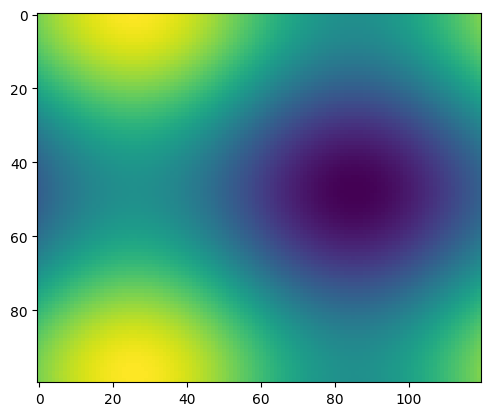

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

fig, ax = plt.subplots()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15
    y += np.pi / 30
    im = ax.imshow(f(x, y), animated=True)
    if i == 0:
        ax.imshow(f(x, y))  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()